In [49]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback

import seaborn as sns

In [50]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [51]:
class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}


with open('mushroom_train.pkl', 'rb') as f:
    data = pickle.load(f)
    y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    X = np.array([data[i]["images"].numpy() for i in range(len(data))])

with open('mushroom_test.pkl', 'rb') as f:
    data = pickle.load(f)
    ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

## Specify learning algorithms

In [98]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [99]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-15,
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_random":
            """
            Added to address the reviewer's comment:
            The authors conduct experiments on "uniform sampling" + "constant step size", "loss-based sampling" + "constant step size", 
            and "loss-based sampling" + "Polyak step size" to verify the effectiveness of the approach of loss-based sampling. For 
            completeness, it is necessary to present the performance of using "uniform sampling" + "Polyak step size" in the numerical experiments.
            """
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = pz0
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [54]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [55]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [56]:
hyperparam_per_algo["absloss"] = {"eta": 300}
hyperparam_per_algo["random"] = {"eta": 300}

In [57]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 35.52674391886635,
  'kappa0': 0.998009193683614,
  'eta': 300,
  'omega': 0.5588345498272365},
 'polyak_exponent': {'kappa': 17.108470703379435,
  'kappa0': 0.4983247553412293,
  'eta': 300,
  'polyakexp': 0.9951814804061615},
 'absloss': {'eta': 300},
 'random': {'eta': 300}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [58]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.5717727128353637, train loss: 0.45616279743150295, ||theta||_1: 17464.45235837473
loss: 0.4973024447436303, train loss: 0.5079317087924428, ||theta||_1: 28799.046233925674
loss: 0.43339784242519713, train loss: 0.583709277818384, ||theta||_1: 39690.972074424375
loss: 0.3855631266935459, train loss: 0.4610780789730974, ||theta||_1: 48440.907851413525
loss: 0.3383048672443234, train loss: 0.47332796336329064, ||theta||_1: 57397.82592740954
loss: 0.3048861596371077, train loss: 0.0033418582346966706, ||theta||_1: 64736.90982719575
loss: 0.28727053067717506, train loss: 0.009165294187140679, ||theta||_1: 69498.61584081559
loss: 0.26802590192523434, train loss: 0.00016368429215703596, ||theta||_1: 73895.73530464894
loss: 0.25281497337155545, train loss: 0.4284848408640223, ||theta||_1: 77346.4165316663
loss: 0.24394255748146848, train loss: 1.950790

In [59]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [60]:
absloss_mean_sampling_prob

0.14784808678301276

In [61]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6569936597265743, train loss: 0.5965703393173747, ||theta||_1: 4901.961314384428
loss: 0.632888078412785, train loss: 0.689622557754829, ||theta||_1: 8879.62052605531
loss: 0.5999723338576848, train loss: 0.5907577566192168, ||theta||_1: 13788.842732351593
loss: 0.5657658721248788, train loss: 0.5924215013916813, ||theta||_1: 19204.068240082193
loss: 0.5359455033499221, train loss: 0.6928267916120839, ||theta||_1: 23450.72793111403
loss: 0.5140563908680199, train loss: 0.6897497268516758, ||theta||_1: 27078.155555278998
loss: 0.48938732868735974, train loss: 0.589597271239129, ||theta||_1: 31227.262671889257
loss: 0.45679980098178474, train loss: 0.00242330099911686, ||theta||_1: 36376.300126197675
loss: 0.4378072524908684, train loss: 0.6173780979061649, ||theta||_1: 39459.831224291374
loss: 0.42272178198366483, train loss: 0.6789541705141717, 

In [62]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6518589339848104, train loss: 0.6931471809288844, ||theta||_1: 4543.260473940717
loss: 0.6225639611332345, train loss: 0.6901418722472507, ||theta||_1: 8696.73475091748
loss: 0.5993144642297624, train loss: 0.5943612732636416, ||theta||_1: 12228.993304876572
loss: 0.5700395790133622, train loss: 0.6896815586923907, ||theta||_1: 16598.799199315617
loss: 0.5298966879178487, train loss: 0.5507966479466854, ||theta||_1: 22431.719037418978
loss: 0.5034043305308976, train loss: 0.6841116046309125, ||theta||_1: 26474.701486727543
loss: 0.47820824839434617, train loss: 0.5842128119674379, ||theta||_1: 30702.31303774632
loss: 0.4577758421645308, train loss: 0.438719373909234, ||theta||_1: 33914.89676600155
loss: 0.44112448705649304, train loss: 0.49422640819474906, ||theta||_1: 36654.50530130546
loss: 0.4239226681209606, train loss: 0.5355011475160747, |

In [63]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6914802275902776, train loss: 0.6931471805599453, ||theta||_1: 174.03449382728803
loss: 0.5767734605424544, train loss: 0.597283972354601, ||theta||_1: 16414.20938601478
loss: 0.5010013688003835, train loss: 0.5129132065357762, ||theta||_1: 28361.822639974365
loss: 0.44727646451098696, train loss: 0.5198823788440825, ||theta||_1: 37956.89047699241
loss: 0.39891826151277887, train loss: 0.4651451175462634, ||theta||_1: 46087.25721756886
loss: 0.3525872959583267, train loss: 0.4420306452226036, ||theta||_1: 54342.01706194354
loss: 0.3253399625378488, train loss: 0.50789855891639, ||theta||_1: 60094.197658779
loss: 0.303514533596707, train loss: 0.43388230357679414, ||theta||_1: 65721.52135167099
loss: 0.28060745521132235, train loss: 0.005225676334425139, ||theta||_1: 71373.84098246886
loss: 0.26507031147463883, train loss: 5.492874552523679e-05, ||theta||_1: 74885.6366249499
loss: 0.24725280999058544, train loss: 1.113

In [64]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

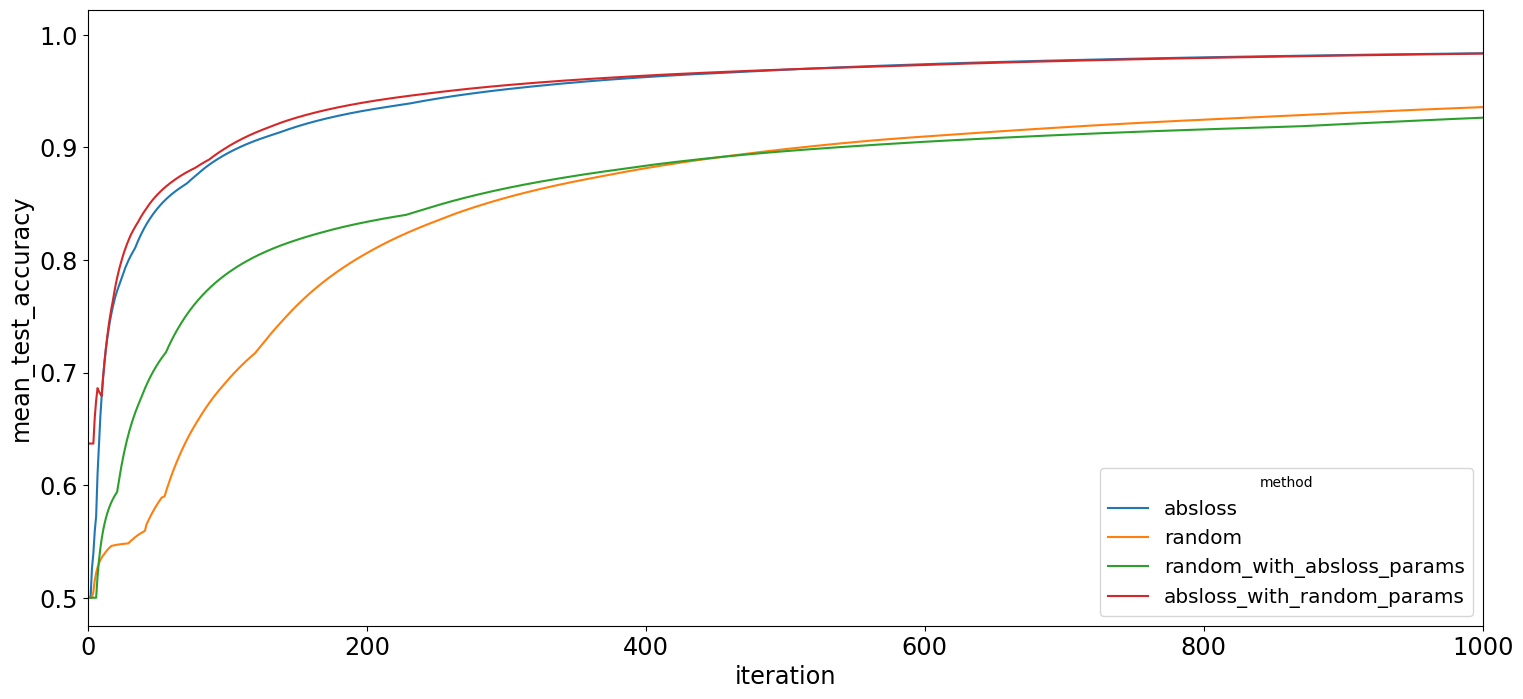

In [65]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

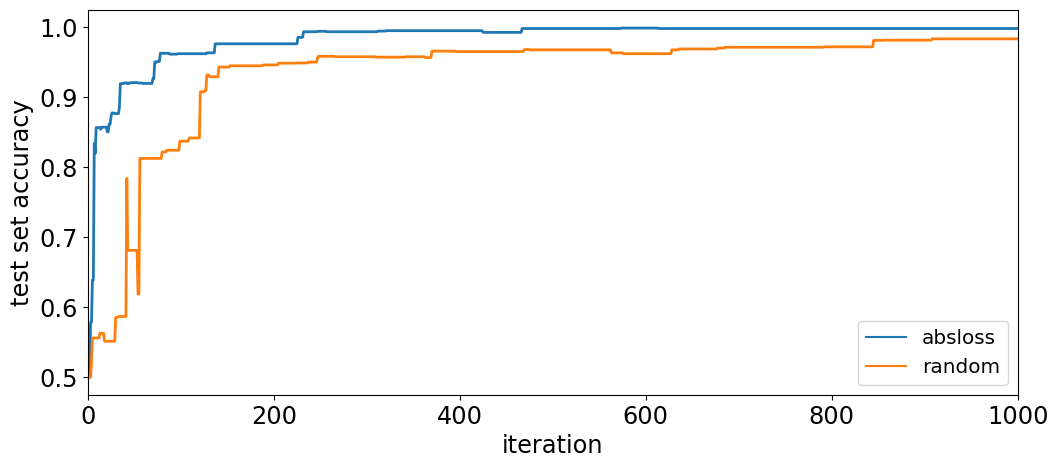

In [66]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig("figure_8a_icml.pdf", format="pdf", bbox_inches="tight")

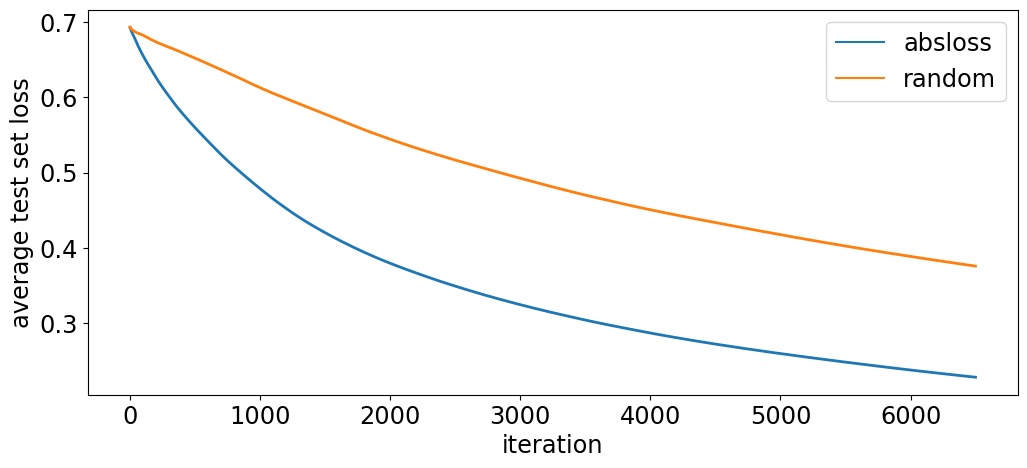

In [67]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig("figure_7a_icml.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

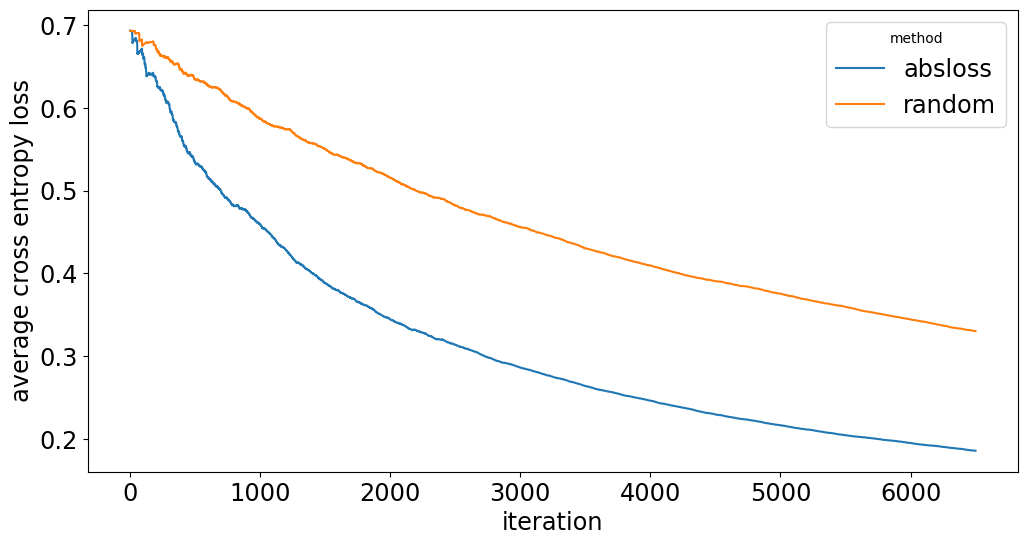

In [68]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

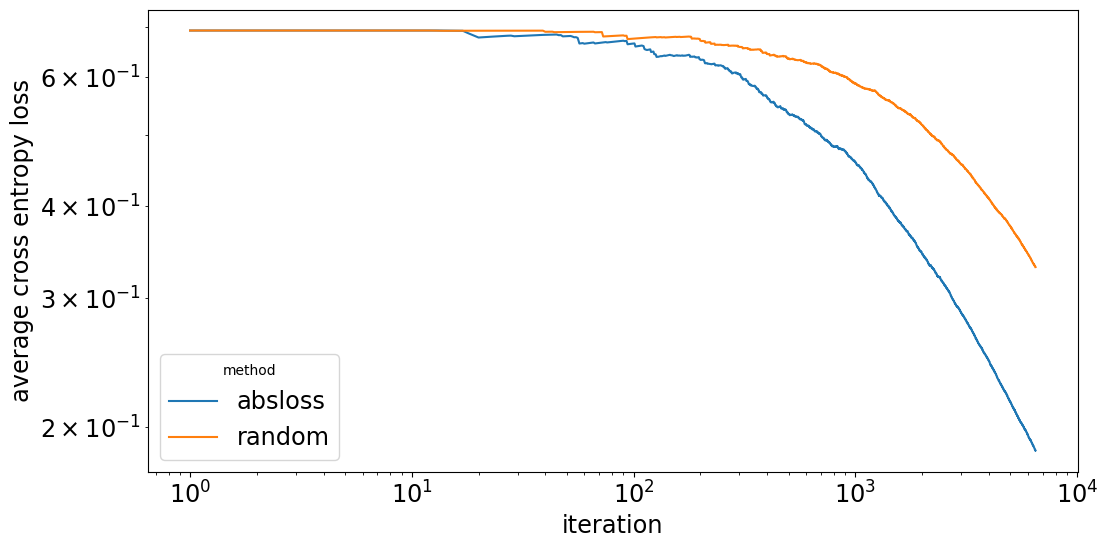

In [69]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [70]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.5786717267359958, train loss: 0.5971723887528995, ||theta||_1: 16675.684490834472
loss: 0.5098701610375013, train loss: 0.0037666519647150845, ||theta||_1: 27878.97100393308
loss: 0.4444771773702762, train loss: 0.003638831814392152, ||theta||_1: 39996.68734556517
loss: 0.38675442661066545, train loss: 0.003523881075465163, ||theta||_1: 50985.85548744934
loss: 0.34005389364127236, train loss: 0.4401329547886434, ||theta||_1: 60028.02514119297
loss: 0.3031685244142961, train loss: 0.0027583791428629147, ||theta||_1: 67791.67872611708
loss: 0.2760800587392707, train loss: 0.5623370228550588, ||theta||_1: 74886.70822095
loss: 0.2532516299533577, train loss: 0.00893411463131629, ||theta||_1: 80630.72734501451
loss: 0.23389671787961708, train loss: 0.0015069350100867524, ||theta||_1: 85012.36409937494
loss: 0.21773521287432973, train loss: 2

In [71]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[6.6118426385456495, 3.3059213192728247, 1.990362960812323, 0.9951814804061615]

In [72]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [73]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [74]:
empirical_pzs

[0.010000000000000014,
 0.10000000000000005,
 0.25000000000000006,
 0.5000000000000001]

In [75]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [76]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [77]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs
polyak_exponent  1.0         0.50     0.156994
                 2.0         0.25     0.202976
                 3.3         0.10     0.251519
                 6.6         0.01     0.520867
random           1.0         0.50     0.152075
                 2.0         0.25     0.253593
                 3.3         0.10     0.386468
                 6.6         0.01     0.642985
Name: train_loss, dtype: float64

In [78]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs
polyak_exponent  1.0         0.50     0.156994
                 2.0         0.25     0.202976
                 3.3         0.10     0.251519
                 6.6         0.01     0.520867
random           1.0         0.50     0.152075
                 2.0         0.25     0.253593
                 3.3         0.10     0.386468
                 6.6         0.01     0.642954
Name: mean_train_loss, dtype: float64

Polyak exp value 6.6 has rows (12998, 16)
Polyak exp value 3.3 has rows (12998, 16)
Polyak exp value 2.0 has rows (12998, 16)
Polyak exp value 1.0 has rows (12998, 16)


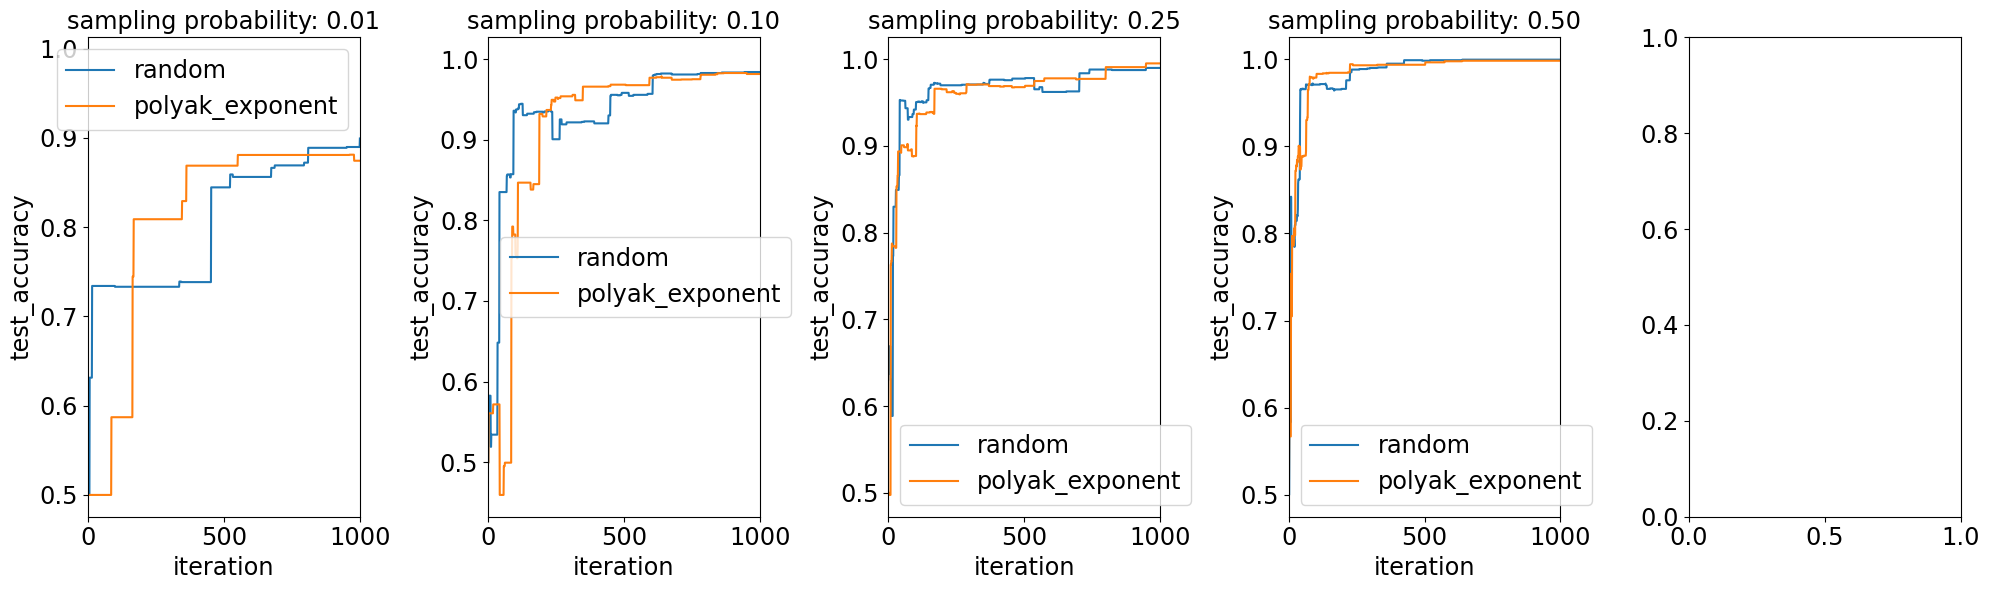

In [79]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 6.6 has rows (12998, 16)
Polyak exp value 3.3 has rows (12998, 16)
Polyak exp value 2.0 has rows (12998, 16)
Polyak exp value 1.0 has rows (12998, 16)


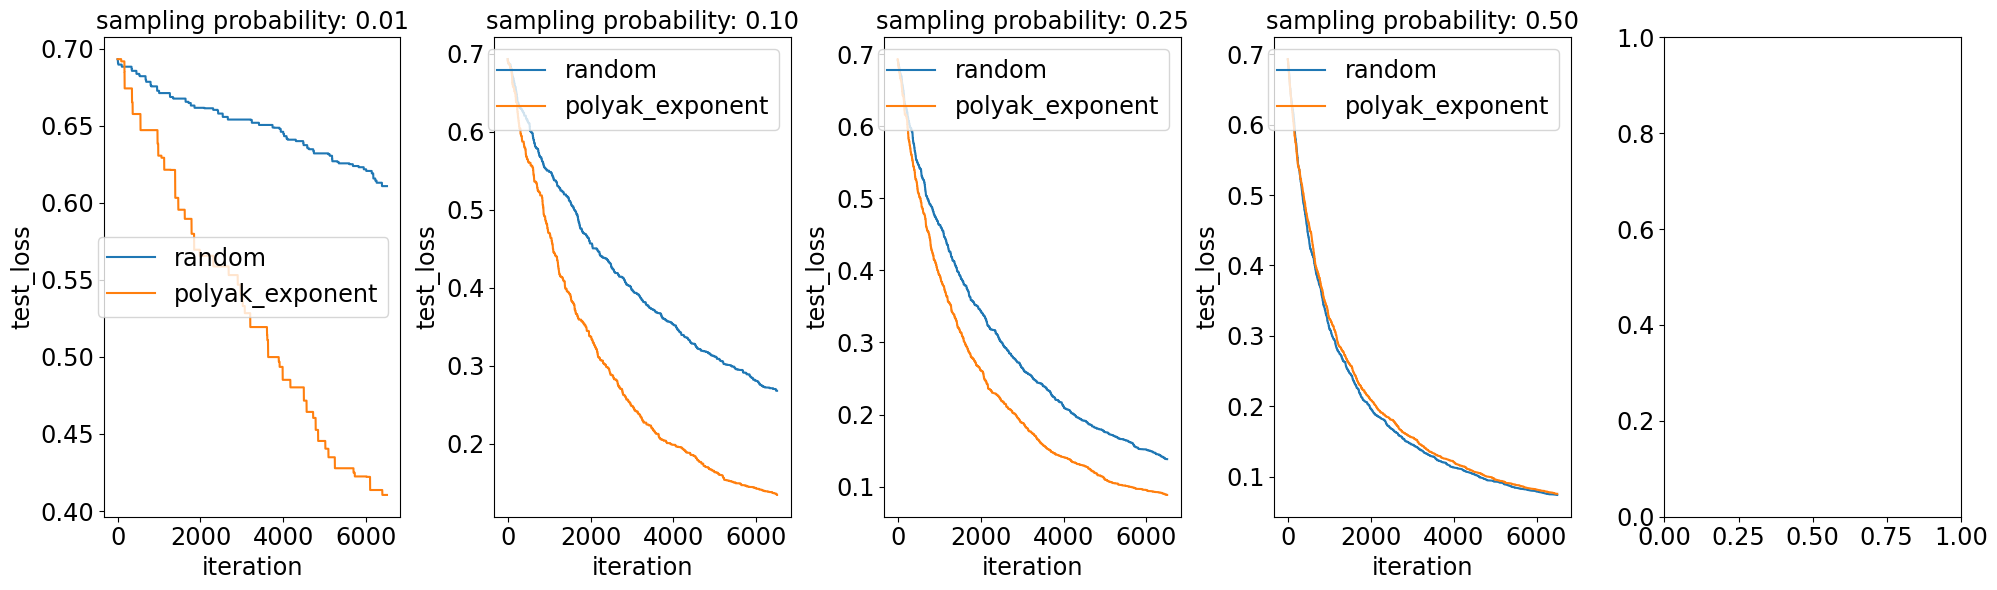

In [80]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [81]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

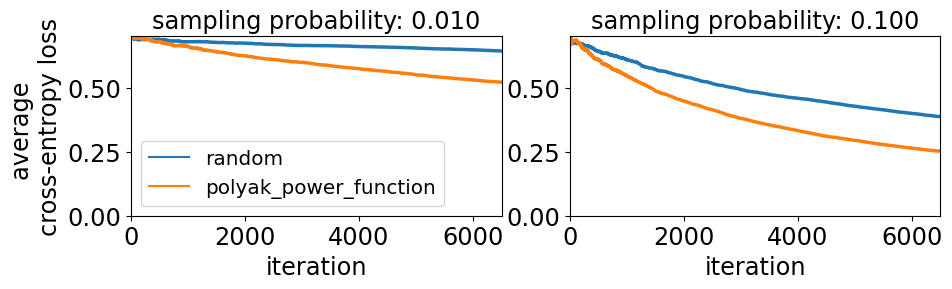

In [82]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 0.7))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig("figure_2_icml.pdf", format="pdf", bbox_inches="tight")

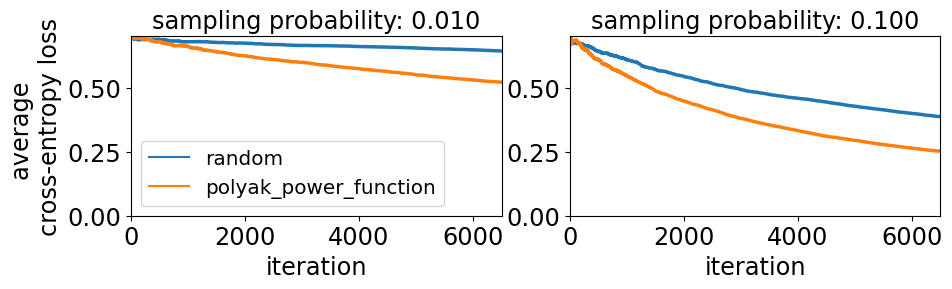

In [83]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 0.7))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig("figure_2_icml.pdf", format="pdf", bbox_inches="tight")

0.010000000000000014
Polyak exp value 6.6 has rows (12998, 16)
0.10000000000000005
Polyak exp value 3.3 has rows (12998, 16)
0.25000000000000006
Polyak exp value 2.0 has rows (12998, 16)
0.5000000000000001
Polyak exp value 1.0 has rows (12998, 16)


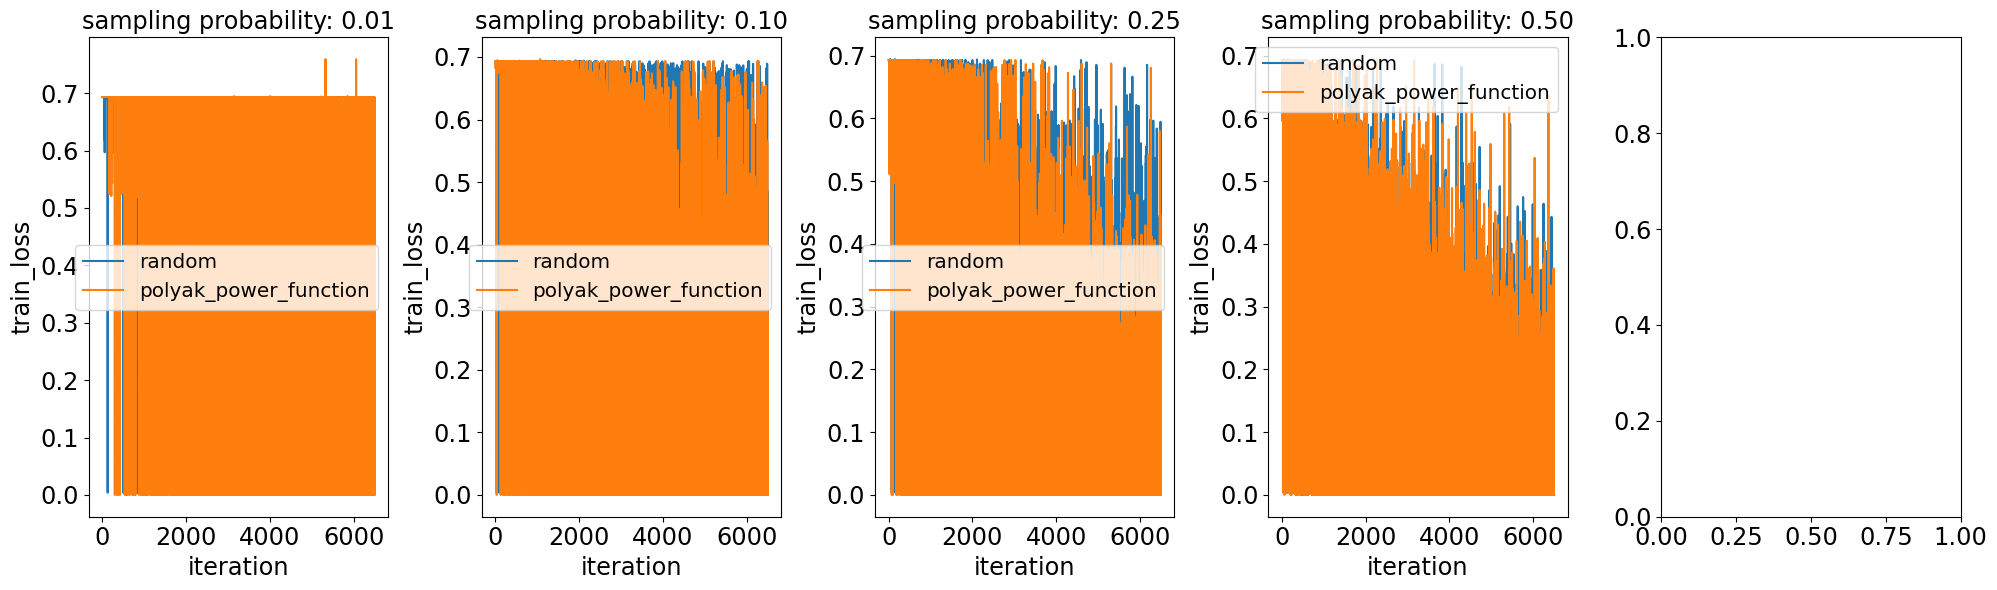

In [84]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.010000000000000014
Polyak exp value 6.6 has rows (12998, 16)
0.10000000000000005
Polyak exp value 3.3 has rows (12998, 16)
0.25000000000000006
Polyak exp value 2.0 has rows (12998, 16)
0.5000000000000001
Polyak exp value 1.0 has rows (12998, 16)


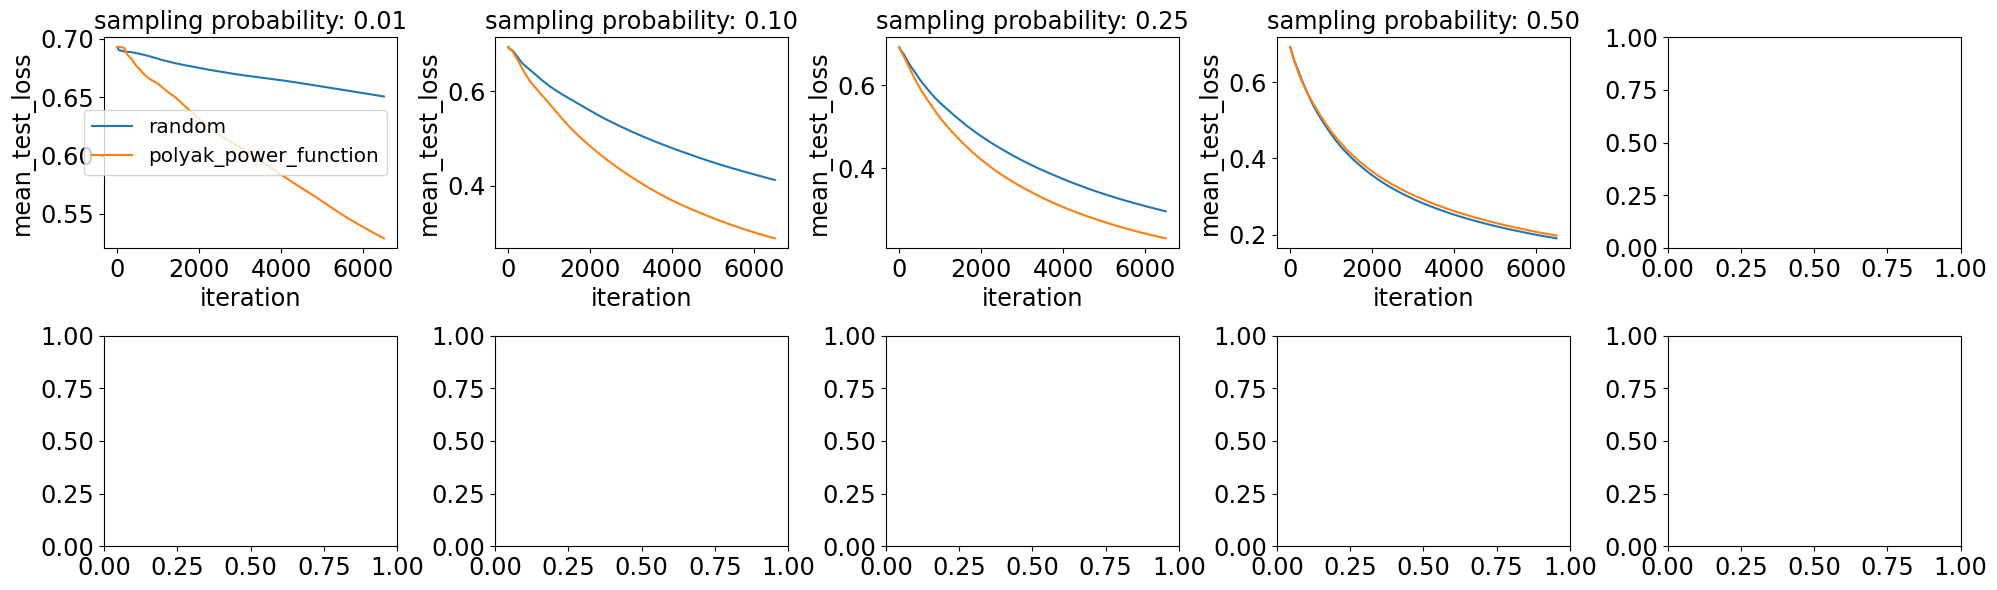

In [85]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [86]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 35.52674391886635,
 'kappa0': 0.998009193683614,
 'eta': 300,
 'omega': 0.5588345498272365}

In [100]:
results_polyak_random = train_model(
    X, y, Xtest, ytest, mode="polyak_random", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"] | {"pz0": absloss_mean_sampling_prob}
)

Training with algorithm polyak_random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6170048024364401, train loss: 0.6924463352646254, ||theta||_1: 25296.156438460355
loss: 0.5215976232344585, train loss: 0.6521098130692505, ||theta||_1: 59462.049438478636
loss: 0.49293078549869207, train loss: 0.6508465350694836, ||theta||_1: 73012.96111653326
loss: 0.43071730463068714, train loss: 0.2946763519759831, ||theta||_1: 97038.69344232691
loss: 0.38247230060266674, train loss: 0.30646770998490636, ||theta||_1: 120602.5775542718
loss: 0.339804479480266, train loss: 0.6920620326223256, ||theta||_1: 141676.25514755977
loss: 0.3218529093713653, train loss: 0.16093779949274672, ||theta||_1: 149374.72755560774
loss: 0.3002722214808317, train loss: 0.00038369511859927524, ||theta||_1: 160306.06325885764
loss: 0.2645860673958935, train loss: 4.440892098500627e-16, ||theta||_1: 177126.40048895206
loss: 0.2530385118149381, train loss: 0.

In [109]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 35.52674391886635, 'kappa0': 0.998009193683614, 'eta': 300, 'omega': 1.9803337578926674}


In [110]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 6499 iterations with d=6499
loss: 0.6914740808535886, train loss: 0.6931471805599453, ||theta||_1: 175.41287277916916
loss: 0.49304005635874637, train loss: 0.4332009320169734, ||theta||_1: 30600.261972716424
loss: 0.3898861519227902, train loss: 0.002027572678054978, ||theta||_1: 50783.726229326705
loss: 0.31674836849416493, train loss: 0.001972172682735703, ||theta||_1: 67433.6836885455
loss: 0.25901090040309577, train loss: 0.0022873931882998, ||theta||_1: 83569.86372223563
loss: 0.2226522143682256, train loss: 0.28941366619171316, ||theta||_1: 94609.125537896
loss: 0.19072064482022724, train loss: 0.00175538000143068, ||theta||_1: 106441.964458797
loss: 0.16919970680246346, train loss: 0.4301775942554256, ||theta||_1: 114572.87048543862
loss: 0.1528001023102962, train loss: 0.0017423713782203857, ||theta||_1: 121976.06777195027
loss: 0.1413240596511477, train loss: 0.001393802994017946, ||theta||_1: 127400.30339382574
loss: 0.1301149041628582

In [111]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

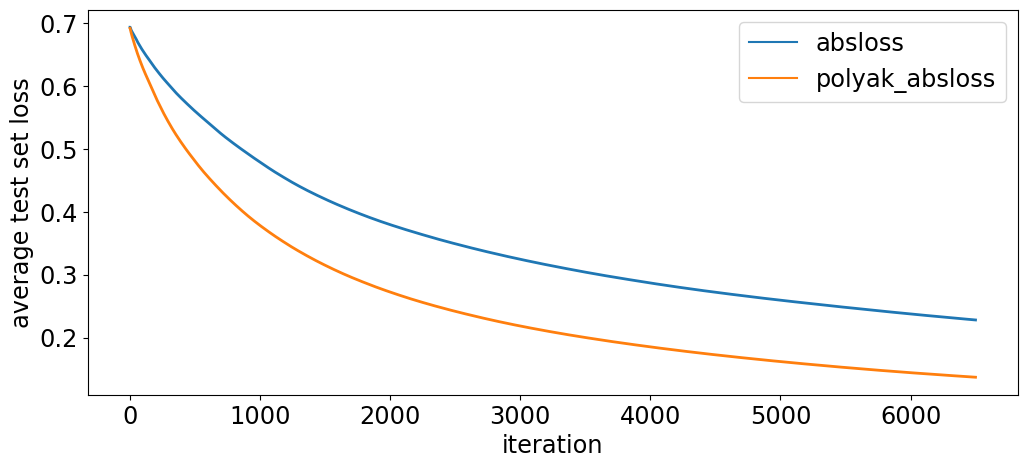

In [112]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig("figure_7b_icml.pdf", format="pdf", bbox_inches="tight")

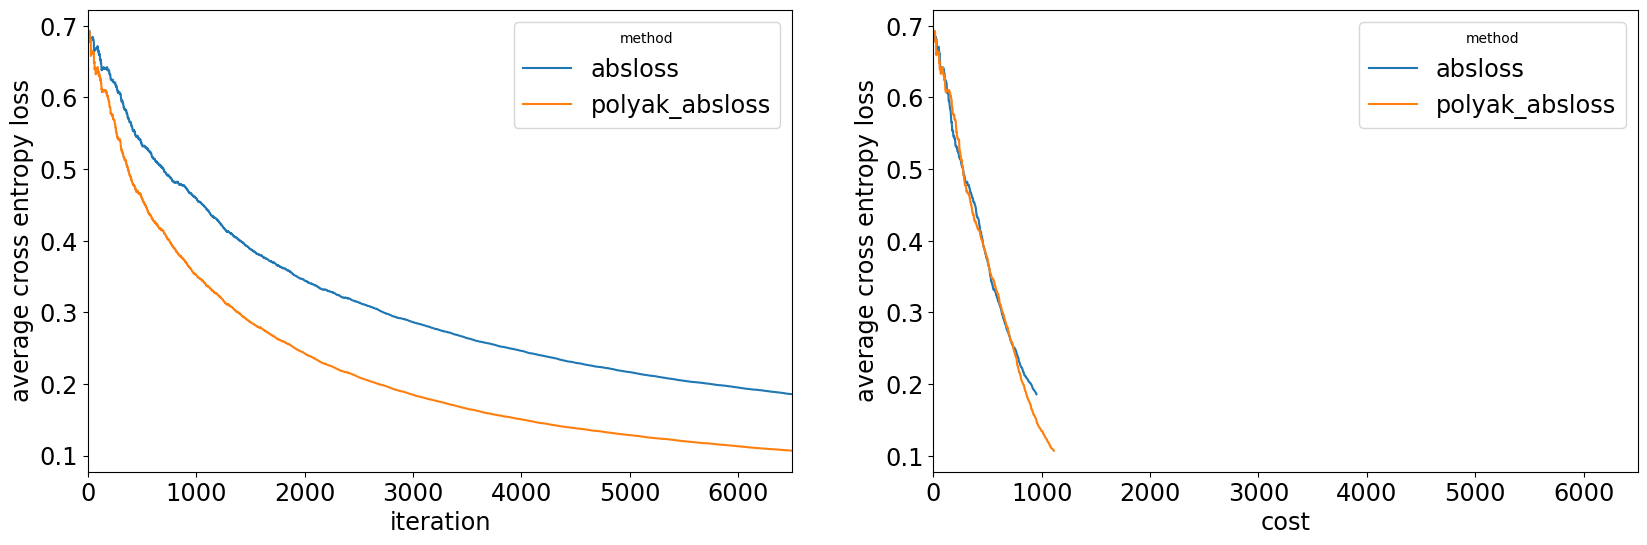

In [113]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

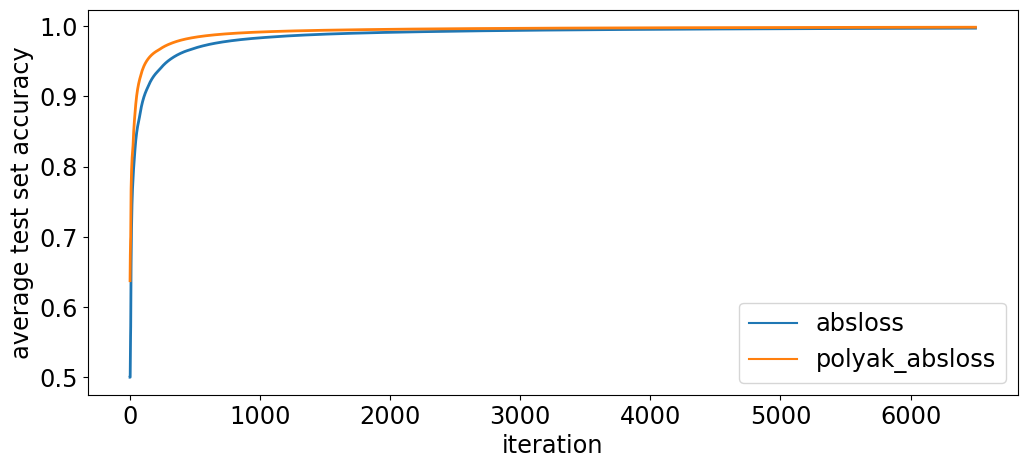

In [114]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig("figure_8b_icml.pdf", format="pdf", bbox_inches="tight")

In [115]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
        "polyak_random": results_polyak_random
    }
)

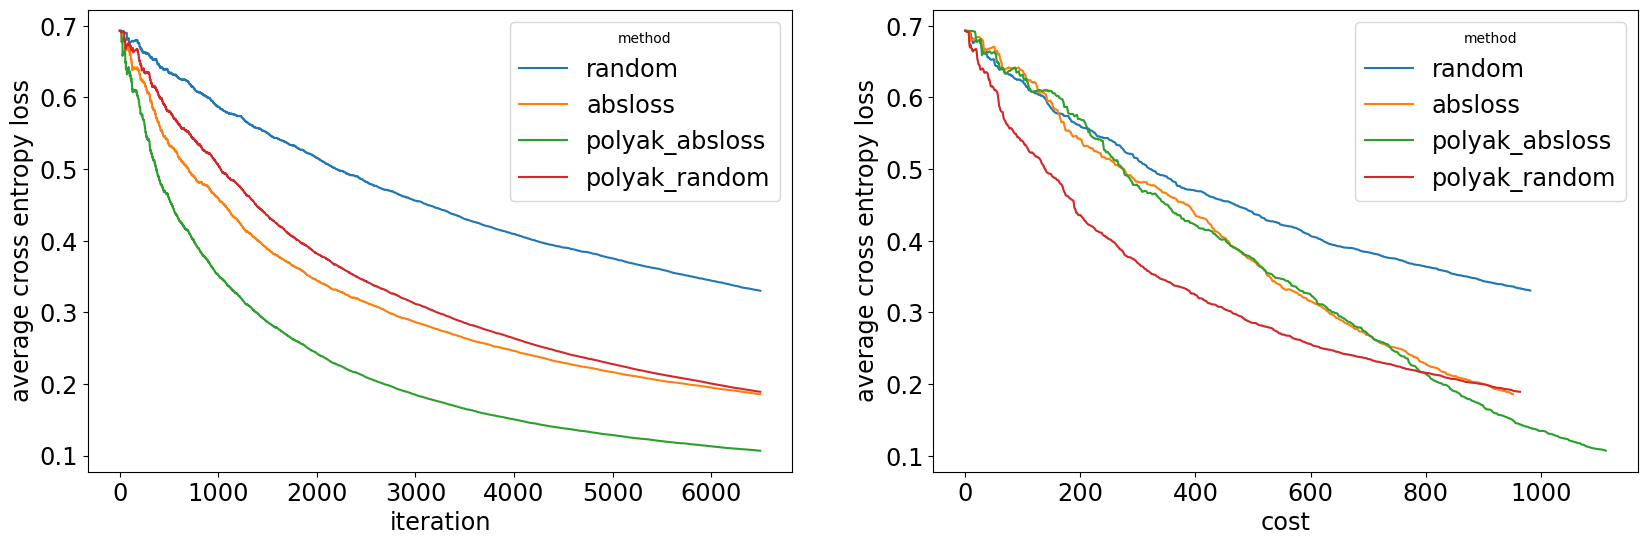

In [116]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

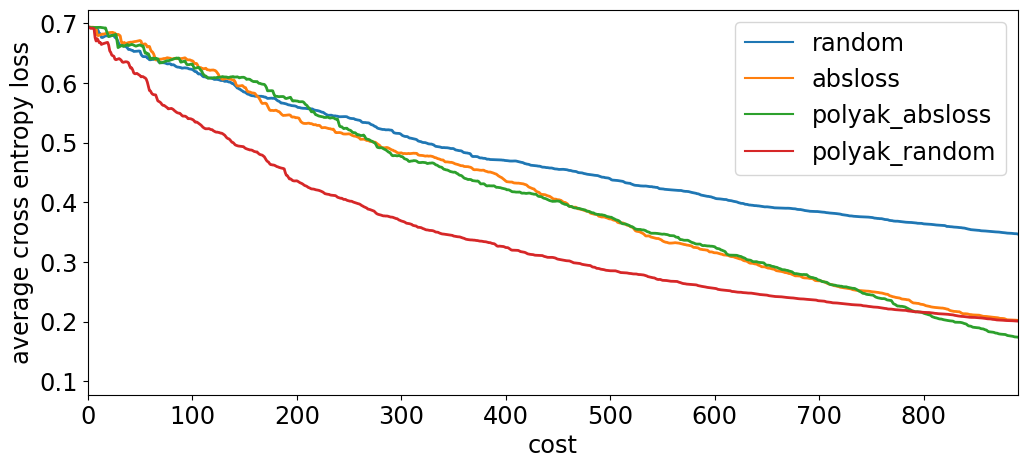

In [121]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig("figure_6_icml.pdf", format="pdf", bbox_inches="tight")

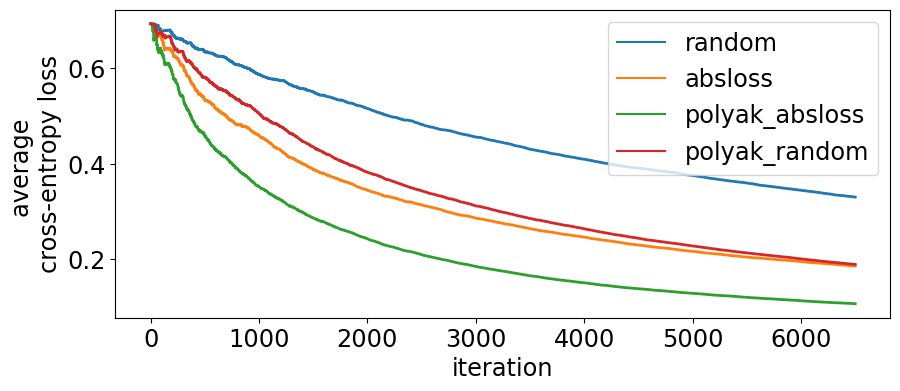

In [118]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig("figure_3_icml_mushrooms.pdf", format="pdf", bbox_inches="tight")
